In [1]:
from datetime import timedelta
import ujson
import pandas as pd
from datetime import datetime
from sklearn import metrics
import praw
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import argparse
import gzip
from nltk.stem.porter import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy
import os
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from tabulate import tabulate
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
def read_csv(path):
    return pd.read_csv(path)

In [3]:
def bow_from_df(df,stemmer):
    
    # Get posts as a list
    posts = list(df['body'])
    for p in posts:
        if type(p) != str:
            posts.remove(posts[posts.index(p)])
    s = ' '.join(posts)
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)

    # Lower case, split string of words into list of words, lemmatize
    document = s.lower()
#    document = document.split()
    #document = [stemmer.lemmatize(word) for word in document]
    return document

In [4]:
def word_counts(df,stemmer):
    
    # Bag of words
    corpus = bow_from_df(df,stemmer).split()
    
    # Get counts for each word in bag
    corpus_counts = Counter(corpus)
    # Create dataframe of words and counts
    corpus_df = pd.DataFrame.from_dict(corpus_counts, orient='index').reset_index()
    corpus_df = corpus_df.rename(columns={'index':'word', 0:'count'})
    # Create column for rank in dataframe
    corpus_df["rank"] = corpus_df['count'].rank(method = 'average',ascending = False) 
    corpus_df = corpus_df.sort_values(by = ['count'],ascending = False)
    
    return corpus_df

In [5]:
def rank_divergence(c1,c2,STEM):
    corpus1_df = word_counts(c1,STEM)
    corpus2_df = word_counts(c2,STEM)
    
    merged = corpus1_df.merge(corpus2_df, on = 'word')
    merged['rank_div'] = abs(merged['rank_y'] - merged['rank_x'])
    merged['importance'] = abs(merged['rank_div'] - (merged['rank_x']**2))*10
    return merged

In [6]:
def subreddit_post(df,subreddit,banned,stemmer):
    df = df[df['subreddit'] == subreddit]
    posts = bow_from_df(df,stemmer)
    return [subreddit, posts, banned]

In [7]:
def cross_val(clf,X,y):
    y_pred = cross_val_predict(clf, X, y, cv=10)
    print(metrics.classification_report(y, y_pred))
    print(metrics.confusion_matrix(y, y_pred))
    return metrics.f1_score(y,y_pred,pos_label=1, average='binary')

In [8]:
# Read in banned and unbanned csv, aggregate posts by subreddit
STEM = WordNetLemmatizer()

    
banned_df = pd.read_csv('banned.csv')
notbanned_df = pd.read_csv('notbanned.csv')
temp = notbanned_df.groupby('subreddit').count()
temp = temp.reset_index()
sample_srs = list(temp['subreddit'].sample(n=117))
notbanned_df = notbanned_df[notbanned_df['subreddit'].isin(sample_srs)]

data = []

for subreddit in banned_df['subreddit'].unique():
    data.append(subreddit_post(banned_df,subreddit,1,STEM))

for subreddit in notbanned_df['subreddit'].unique():
    data.append(subreddit_post(notbanned_df,subreddit,0,STEM)) 

(array([117.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 117.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

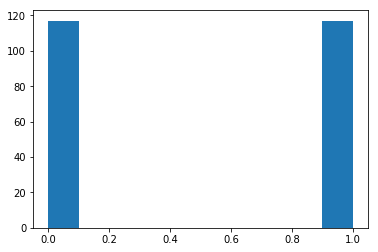

In [9]:
sr_df = pd.DataFrame(data, columns = ['subreddit','posts','banned'])
rank_df = rank_divergence(banned_df,notbanned_df,STEM)
#rank_div = np.matrix(rank_df['rank_div'])
#r = np.dot(rank_div.T,rank_div)
plt.hist(sr_df['banned'])

In [10]:
corpus = sr_df['posts']
tfidf = CountVectorizer(max_features = len(rank_df))

X = tfidf.fit_transform(corpus)
y = sr_df['banned']

In [11]:
# Transformation
#counts = scipy.sparse.diags(rank_df.rank_div, 0)
counts = np.tile(rank_df.rank_div,(X.shape[1],1))
print(counts.shape)
X_rankdiv = (X*counts)
counts_importance = scipy.sparse.diags(rank_df.importance, 0)
X_importance = (X*counts_importance)

(4778, 4778)


In [12]:
def rankdiv_vs_not(clf,X,y):
    clf = clf.fit(X, y)
    return cross_val(clf, X, y)

In [13]:
def word_embedding_hist(X):
    plt.hist(X)
    plt.show()
    
#print(X_rankdiv)

In [14]:
scores = []
clf = MultinomialNB()
d = rankdiv_vs_not(clf,X,y)
scores.append(['MNB','TF-IDF',d])
d = rankdiv_vs_not(clf,X_rankdiv,y)
scores.append(['MNB','TF-IDF+RD',d])

              precision    recall  f1-score   support

           0       0.73      0.53      0.61       117
           1       0.63      0.80      0.71       117

   micro avg       0.67      0.67      0.67       234
   macro avg       0.68      0.67      0.66       234
weighted avg       0.68      0.67      0.66       234

[[62 55]
 [23 94]]
              precision    recall  f1-score   support

           0       0.44      0.03      0.06       117
           1       0.50      0.96      0.65       117

   micro avg       0.50      0.50      0.50       234
   macro avg       0.47      0.50      0.36       234
weighted avg       0.47      0.50      0.36       234

[[  4 113]
 [  5 112]]


In [15]:
temp = []
clf = DecisionTreeClassifier()
d = rankdiv_vs_not(clf,X,y)
scores.append(['DT','TF-IDF',d])
d = rankdiv_vs_not(clf,X_rankdiv,y)
scores.append(['DT','TF-IDF+RD',d])

              precision    recall  f1-score   support

           0       0.62      0.67      0.64       117
           1       0.64      0.60      0.62       117

   micro avg       0.63      0.63      0.63       234
   macro avg       0.63      0.63      0.63       234
weighted avg       0.63      0.63      0.63       234

[[78 39]
 [47 70]]
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       117
           1       0.52      0.44      0.47       117

   micro avg       0.52      0.52      0.52       234
   macro avg       0.52      0.52      0.51       234
weighted avg       0.52      0.52      0.51       234

[[70 47]
 [66 51]]


In [16]:
temp = []
clf = SVC()
d = rankdiv_vs_not(clf,X,y)
scores.append(['SVC','TF-IDF',d])
d = rankdiv_vs_not(clf,X_rankdiv,y)
scores.append(['SVC','TF-IDF+RD',d])

/Users/kellyg/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kellyg/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.58      0.91      0.71       117
           1       0.79      0.32      0.46       117

   micro avg       0.62      0.62      0.62       234
   macro avg       0.68      0.62      0.58       234
weighted avg       0.68      0.62      0.58       234

[[107  10]
 [ 79  38]]


/Users/kellyg/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kellyg/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kellyg/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kellyg/anaconda3/lib/python3.7/site-packages/

              precision    recall  f1-score   support

           0       0.51      0.28      0.36       117
           1       0.50      0.73      0.59       117

   micro avg       0.50      0.50      0.50       234
   macro avg       0.51      0.50      0.48       234
weighted avg       0.51      0.50      0.48       234

[[33 84]
 [32 85]]


In [17]:
clf = RandomForestClassifier(n_estimators = 50, class_weight = 'balanced')
d = rankdiv_vs_not(clf,X,y)
scores.append(['RF','TF-IDF',d])
d = rankdiv_vs_not(clf,X_rankdiv,y)
scores.append(['RF','TF-IDF+RD',d])

              precision    recall  f1-score   support

           0       0.58      0.75      0.66       117
           1       0.65      0.46      0.54       117

   micro avg       0.61      0.61      0.61       234
   macro avg       0.62      0.61      0.60       234
weighted avg       0.62      0.61      0.60       234

[[88 29]
 [63 54]]
              precision    recall  f1-score   support

           0       0.50      0.55      0.52       117
           1       0.50      0.46      0.48       117

   micro avg       0.50      0.50      0.50       234
   macro avg       0.50      0.50      0.50       234
weighted avg       0.50      0.50      0.50       234

[[64 53]
 [63 54]]


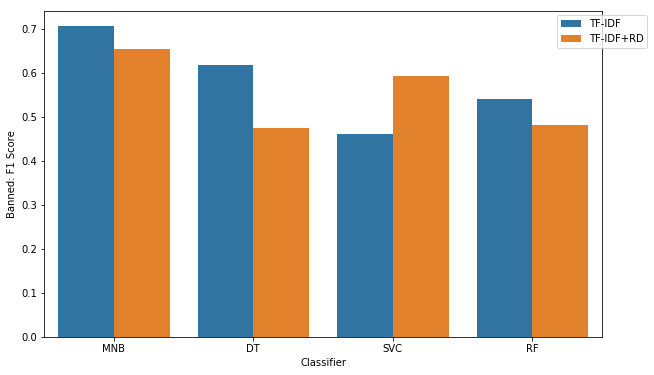

In [18]:
df = pd.DataFrame(scores,columns=['clf','vec','f1'])
plt.figure(figsize=(10, 6))
sns.barplot(x="clf", hue="vec", y="f1", data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=9, borderaxespad=0.4)
plt.xlabel('Classifier')
plt.ylabel('Banned: F1 Score')
plt.savefig('clf_barplot.png')